<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/tuned_cnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
!pip install keras-tuner

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\camjt\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\camjt\AppData\Local\Temp\ipykernel_7668\353367028.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

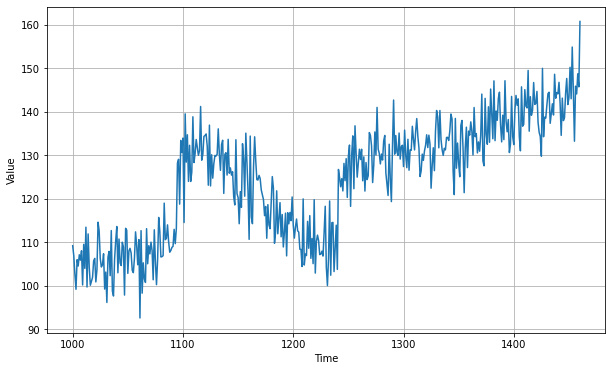

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding='causal', activation='relu', input_shape=[None, 1]))
  
  model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=0.5, lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 14 Complete [00h 00m 36s]
loss: 59.96169662475586

Best loss So Far: 59.68549346923828
Total elapsed time: 00h 08m 44s
INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.results_summary()

Results summary
Results in my_dir\cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 59.68549346923828
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 59.96169662475586
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 60.146217346191406
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.498608907063804
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
Score: 61.61287180582682
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 2
Score: 61.702868143717446
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 61.714027404785156
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 61.7950693766276
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 3
Score: 62.221875508626304
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 3
Score: 62.26006952921549


In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=9,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 547.5898
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 118.8032
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 85.4971
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 75.0022
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 70.9342
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 67.9932
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 65.2147
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 65.0262
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 65.4029
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 65.1065
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 63.1374
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 63.7720
Epoch 13/100
31/31 [===

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 2ms/step


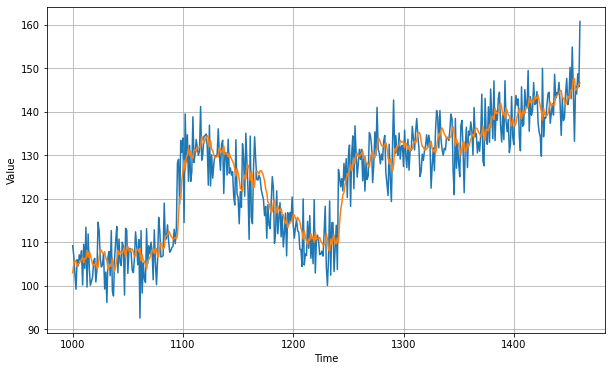

In [13]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.519653